# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

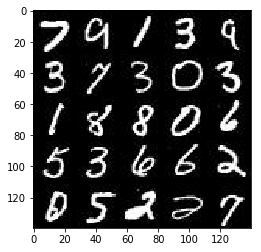

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

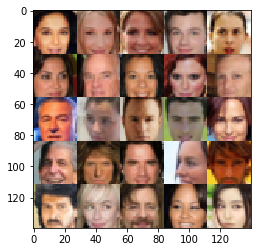

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [7]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real=tf.placeholder(tf.float32,shape=(None,image_width,image_height,image_channels),name='inputs_real')
    inputs_z=tf.placeholder(tf.float32,shape=(None,z_dim),name='inputs_z')
    learning_rate=tf.placeholder(tf.float32,name='learnrate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [8]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(0.2 * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(0.2 * x2, x2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(0.2 * x3, x3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha=0.2
    with tf.variable_scope('generator',reuse= not is_train):
        # First fully connected layer
        
        x1 = tf.layers.dense(z, 2*2*1024)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 1024))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1=tf.nn.dropout(x1,0.7)
        # 2x2x1024 now
        #print(x1.shape)
        x2 = tf.layers.conv2d_transpose(x1, 512, 4, strides=2, padding='same')
        #x2 = tf.reshape(x1, (-1, 7, 7, 256))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha* x2, x2)
        x2=tf.nn.dropout(x2,0.7)
        #print(x2.shape)
        # 4x4x512 now
        
        x3 = tf.layers.conv2d_transpose(x2, 256, 4,strides=1, padding='valid')
        #x2 = tf.reshape(x1, (-1, 7, 7, 256))
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha* x3, x3)
        x3=tf.nn.dropout(x3,0.7)
        #print(x3.shape)
        # 7x7x256 now
        
        x4 = tf.layers.conv2d_transpose(x3, 128, 4, strides=2, padding='same')
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha* x4, x4)
        x4=tf.nn.dropout(x4,0.7)
        #print(x4.shape)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 4, strides=2, padding='same')
        #print(logits.shape)
        # 32x32x3 now
        #logits=tf.resh
        
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model=generator(input_z,out_channel_dim,True)
    d_model_real,d_logits_real=discriminator(input_real,False)
    d_model_fake,d_logits_fake=discriminator(g_model,reuse=True)
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars=tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    inputs_real, inputs_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
           
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[-1])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                #print('batch_z shape=',batch_z.shape)
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z,lr:learning_rate})
                #print('Hi')
                _ = sess.run(g_opt, feed_dict={inputs_z: batch_z, inputs_real: batch_images,lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={inputs_z: batch_z, inputs_real: batch_images,lr:learning_rate})
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                   

                if steps % 100 == 0:
                    show_generator_output(sess, 25, inputs_z, data_shape[3], data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 4.6416... Generator Loss: 0.0159
Epoch 1/2... Discriminator Loss: 3.6097... Generator Loss: 0.3650
Epoch 1/2... Discriminator Loss: 1.8235... Generator Loss: 1.3596
Epoch 1/2... Discriminator Loss: 1.3264... Generator Loss: 0.8706
Epoch 1/2... Discriminator Loss: 1.8134... Generator Loss: 0.4267
Epoch 1/2... Discriminator Loss: 0.9190... Generator Loss: 1.0690
Epoch 1/2... Discriminator Loss: 1.0888... Generator Loss: 1.1882
Epoch 1/2... Discriminator Loss: 2.0786... Generator Loss: 0.3242
Epoch 1/2... Discriminator Loss: 2.2144... Generator Loss: 0.3735
Epoch 1/2... Discriminator Loss: 1.5915... Generator Loss: 1.3616


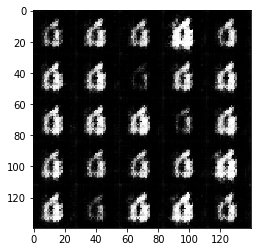

Epoch 1/2... Discriminator Loss: 0.7981... Generator Loss: 1.6346
Epoch 1/2... Discriminator Loss: 1.7129... Generator Loss: 0.6989
Epoch 1/2... Discriminator Loss: 0.6396... Generator Loss: 2.0589
Epoch 1/2... Discriminator Loss: 1.5492... Generator Loss: 0.5246
Epoch 1/2... Discriminator Loss: 1.1267... Generator Loss: 1.9815
Epoch 1/2... Discriminator Loss: 1.1733... Generator Loss: 1.2011
Epoch 1/2... Discriminator Loss: 0.8471... Generator Loss: 1.9503
Epoch 1/2... Discriminator Loss: 0.7190... Generator Loss: 2.3525
Epoch 1/2... Discriminator Loss: 1.3788... Generator Loss: 1.1999
Epoch 1/2... Discriminator Loss: 0.7446... Generator Loss: 1.8175


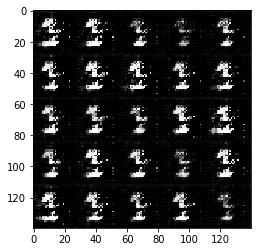

Epoch 1/2... Discriminator Loss: 1.0292... Generator Loss: 1.0785
Epoch 1/2... Discriminator Loss: 2.2240... Generator Loss: 0.9201
Epoch 1/2... Discriminator Loss: 1.0549... Generator Loss: 1.6130
Epoch 1/2... Discriminator Loss: 0.7369... Generator Loss: 2.6351
Epoch 1/2... Discriminator Loss: 0.8597... Generator Loss: 1.1731
Epoch 1/2... Discriminator Loss: 1.1321... Generator Loss: 0.9415
Epoch 1/2... Discriminator Loss: 0.7697... Generator Loss: 1.8948
Epoch 1/2... Discriminator Loss: 0.7007... Generator Loss: 1.9546
Epoch 1/2... Discriminator Loss: 1.0811... Generator Loss: 1.9830
Epoch 1/2... Discriminator Loss: 1.7313... Generator Loss: 3.7218


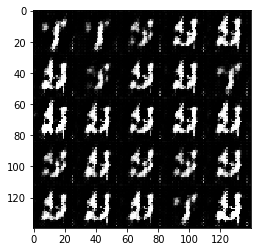

Epoch 1/2... Discriminator Loss: 0.8613... Generator Loss: 1.9630
Epoch 1/2... Discriminator Loss: 1.9054... Generator Loss: 0.9083
Epoch 1/2... Discriminator Loss: 0.9612... Generator Loss: 1.2586
Epoch 1/2... Discriminator Loss: 1.1190... Generator Loss: 1.2360
Epoch 1/2... Discriminator Loss: 0.9108... Generator Loss: 1.3957
Epoch 1/2... Discriminator Loss: 0.8637... Generator Loss: 1.5579
Epoch 1/2... Discriminator Loss: 1.1882... Generator Loss: 0.8609
Epoch 1/2... Discriminator Loss: 1.4258... Generator Loss: 0.7346
Epoch 1/2... Discriminator Loss: 1.1834... Generator Loss: 0.9048
Epoch 1/2... Discriminator Loss: 0.9349... Generator Loss: 1.5892


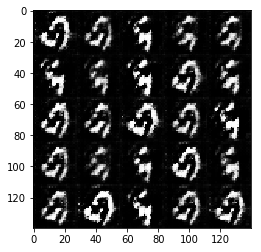

Epoch 1/2... Discriminator Loss: 1.1033... Generator Loss: 1.2919
Epoch 1/2... Discriminator Loss: 1.2269... Generator Loss: 0.6916
Epoch 1/2... Discriminator Loss: 1.3121... Generator Loss: 1.3056
Epoch 1/2... Discriminator Loss: 1.0776... Generator Loss: 1.3111
Epoch 1/2... Discriminator Loss: 0.7293... Generator Loss: 2.5444


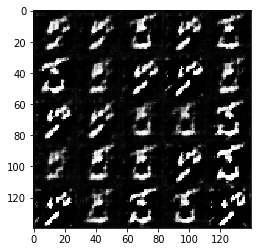

Epoch 1/2... Discriminator Loss: 0.9785... Generator Loss: 1.5993
Epoch 1/2... Discriminator Loss: 0.9810... Generator Loss: 1.3395
Epoch 1/2... Discriminator Loss: 0.8416... Generator Loss: 1.1182
Epoch 1/2... Discriminator Loss: 0.9651... Generator Loss: 2.6275
Epoch 1/2... Discriminator Loss: 1.3170... Generator Loss: 1.0298
Epoch 1/2... Discriminator Loss: 1.3909... Generator Loss: 0.6946
Epoch 1/2... Discriminator Loss: 1.0080... Generator Loss: 1.5013
Epoch 1/2... Discriminator Loss: 0.9631... Generator Loss: 1.1652
Epoch 1/2... Discriminator Loss: 0.8762... Generator Loss: 1.9829
Epoch 1/2... Discriminator Loss: 1.0695... Generator Loss: 0.8307


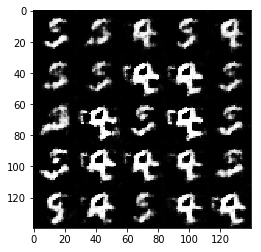

Epoch 1/2... Discriminator Loss: 0.9826... Generator Loss: 1.4741
Epoch 1/2... Discriminator Loss: 0.8565... Generator Loss: 1.3984
Epoch 1/2... Discriminator Loss: 1.0651... Generator Loss: 0.9220
Epoch 1/2... Discriminator Loss: 0.9386... Generator Loss: 1.1889
Epoch 1/2... Discriminator Loss: 0.9635... Generator Loss: 1.1315
Epoch 1/2... Discriminator Loss: 0.8553... Generator Loss: 1.8508
Epoch 1/2... Discriminator Loss: 1.3172... Generator Loss: 1.0883
Epoch 1/2... Discriminator Loss: 1.2621... Generator Loss: 1.2572
Epoch 1/2... Discriminator Loss: 1.1242... Generator Loss: 1.0526
Epoch 1/2... Discriminator Loss: 1.3680... Generator Loss: 3.1375


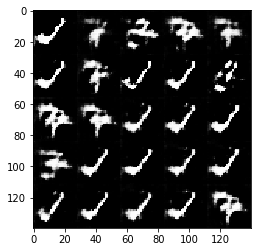

Epoch 1/2... Discriminator Loss: 0.8213... Generator Loss: 1.9559
Epoch 1/2... Discriminator Loss: 1.0649... Generator Loss: 1.3279
Epoch 1/2... Discriminator Loss: 1.2989... Generator Loss: 0.7874
Epoch 1/2... Discriminator Loss: 0.9208... Generator Loss: 1.2242
Epoch 1/2... Discriminator Loss: 0.8804... Generator Loss: 1.2606
Epoch 1/2... Discriminator Loss: 1.6542... Generator Loss: 3.1324
Epoch 1/2... Discriminator Loss: 1.2164... Generator Loss: 0.8494
Epoch 1/2... Discriminator Loss: 0.9736... Generator Loss: 1.2840
Epoch 1/2... Discriminator Loss: 1.5651... Generator Loss: 0.5293
Epoch 1/2... Discriminator Loss: 1.0252... Generator Loss: 1.1429


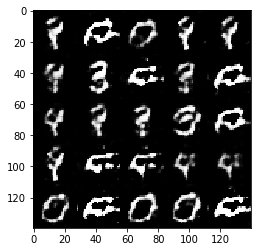

Epoch 1/2... Discriminator Loss: 0.7584... Generator Loss: 1.8225
Epoch 1/2... Discriminator Loss: 0.8753... Generator Loss: 1.6017
Epoch 1/2... Discriminator Loss: 0.7141... Generator Loss: 2.0498
Epoch 1/2... Discriminator Loss: 0.9922... Generator Loss: 1.1649
Epoch 1/2... Discriminator Loss: 0.8825... Generator Loss: 1.7963
Epoch 1/2... Discriminator Loss: 0.8972... Generator Loss: 2.3010
Epoch 1/2... Discriminator Loss: 0.9856... Generator Loss: 0.9560
Epoch 1/2... Discriminator Loss: 0.9671... Generator Loss: 1.7790
Epoch 1/2... Discriminator Loss: 1.0814... Generator Loss: 1.0320
Epoch 1/2... Discriminator Loss: 1.0176... Generator Loss: 1.0308


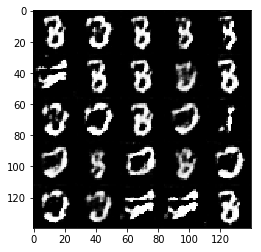

Epoch 1/2... Discriminator Loss: 0.9444... Generator Loss: 1.1590
Epoch 1/2... Discriminator Loss: 1.1019... Generator Loss: 1.5129
Epoch 1/2... Discriminator Loss: 1.0147... Generator Loss: 0.9417
Epoch 2/2... Discriminator Loss: 1.1309... Generator Loss: 2.8147
Epoch 2/2... Discriminator Loss: 1.0248... Generator Loss: 1.0935
Epoch 2/2... Discriminator Loss: 1.1184... Generator Loss: 1.0397
Epoch 2/2... Discriminator Loss: 0.8485... Generator Loss: 1.2359
Epoch 2/2... Discriminator Loss: 1.5210... Generator Loss: 3.4318
Epoch 2/2... Discriminator Loss: 1.1509... Generator Loss: 0.8824
Epoch 2/2... Discriminator Loss: 0.9633... Generator Loss: 1.1641


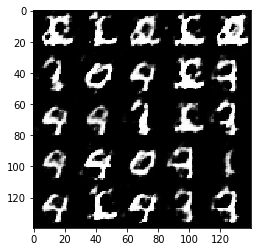

Epoch 2/2... Discriminator Loss: 0.7734... Generator Loss: 1.5889
Epoch 2/2... Discriminator Loss: 0.9900... Generator Loss: 1.7414
Epoch 2/2... Discriminator Loss: 1.0034... Generator Loss: 1.1496
Epoch 2/2... Discriminator Loss: 0.9818... Generator Loss: 1.0798
Epoch 2/2... Discriminator Loss: 0.8357... Generator Loss: 1.6347
Epoch 2/2... Discriminator Loss: 1.1686... Generator Loss: 3.2932
Epoch 2/2... Discriminator Loss: 0.7335... Generator Loss: 1.5269
Epoch 2/2... Discriminator Loss: 0.8075... Generator Loss: 1.4162
Epoch 2/2... Discriminator Loss: 0.8771... Generator Loss: 1.3848
Epoch 2/2... Discriminator Loss: 0.9653... Generator Loss: 0.9254


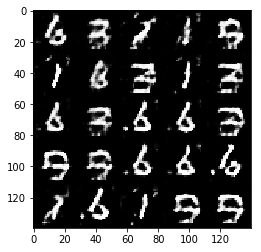

Epoch 2/2... Discriminator Loss: 0.9875... Generator Loss: 1.1555
Epoch 2/2... Discriminator Loss: 0.8243... Generator Loss: 1.4920
Epoch 2/2... Discriminator Loss: 0.9204... Generator Loss: 1.8195
Epoch 2/2... Discriminator Loss: 0.8364... Generator Loss: 1.5951
Epoch 2/2... Discriminator Loss: 0.8130... Generator Loss: 1.8514
Epoch 2/2... Discriminator Loss: 1.1342... Generator Loss: 0.8965
Epoch 2/2... Discriminator Loss: 1.0864... Generator Loss: 2.5929
Epoch 2/2... Discriminator Loss: 1.1055... Generator Loss: 0.9142
Epoch 2/2... Discriminator Loss: 0.9214... Generator Loss: 1.2653
Epoch 2/2... Discriminator Loss: 0.7005... Generator Loss: 1.8320


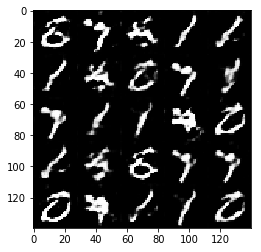

Epoch 2/2... Discriminator Loss: 1.5299... Generator Loss: 0.5244
Epoch 2/2... Discriminator Loss: 0.9382... Generator Loss: 1.0670
Epoch 2/2... Discriminator Loss: 1.0254... Generator Loss: 1.0156
Epoch 2/2... Discriminator Loss: 0.9579... Generator Loss: 1.6342
Epoch 2/2... Discriminator Loss: 0.7983... Generator Loss: 1.8850
Epoch 2/2... Discriminator Loss: 0.8565... Generator Loss: 1.6652
Epoch 2/2... Discriminator Loss: 0.8019... Generator Loss: 1.5200
Epoch 2/2... Discriminator Loss: 0.9212... Generator Loss: 1.2254
Epoch 2/2... Discriminator Loss: 0.7021... Generator Loss: 2.2086
Epoch 2/2... Discriminator Loss: 1.6440... Generator Loss: 0.3364
Epoch 2/2... Discriminator Loss: 0.7169... Generator Loss: 1.9852
Epoch 2/2... Discriminator Loss: 1.2203... Generator Loss: 0.8037
Epoch 2/2... Discriminator Loss: 0.9627... Generator Loss: 0.9839
Epoch 2/2... Discriminator Loss: 0.9311... Generator Loss: 1.2644
Epoch 2/2... Discriminator Loss: 1.0865... Generator Loss: 1.0493
Epoch 2/2.

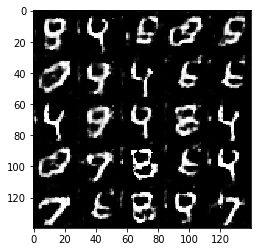

Epoch 2/2... Discriminator Loss: 1.0600... Generator Loss: 3.0635
Epoch 2/2... Discriminator Loss: 0.8798... Generator Loss: 1.5238
Epoch 2/2... Discriminator Loss: 0.9575... Generator Loss: 1.5726
Epoch 2/2... Discriminator Loss: 0.7099... Generator Loss: 1.6916
Epoch 2/2... Discriminator Loss: 0.6733... Generator Loss: 2.0759
Epoch 2/2... Discriminator Loss: 0.8151... Generator Loss: 1.3890
Epoch 2/2... Discriminator Loss: 0.8544... Generator Loss: 1.5866
Epoch 2/2... Discriminator Loss: 0.7668... Generator Loss: 1.6704
Epoch 2/2... Discriminator Loss: 1.4674... Generator Loss: 4.1191
Epoch 2/2... Discriminator Loss: 0.6516... Generator Loss: 2.2640


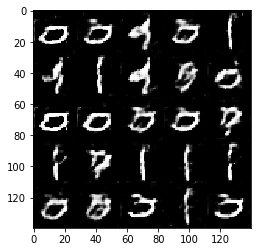

Epoch 2/2... Discriminator Loss: 0.9949... Generator Loss: 2.4583
Epoch 2/2... Discriminator Loss: 0.8335... Generator Loss: 1.1834
Epoch 2/2... Discriminator Loss: 0.6835... Generator Loss: 2.4671
Epoch 2/2... Discriminator Loss: 0.8823... Generator Loss: 1.1736
Epoch 2/2... Discriminator Loss: 0.6143... Generator Loss: 2.2868
Epoch 2/2... Discriminator Loss: 0.6187... Generator Loss: 1.8961
Epoch 2/2... Discriminator Loss: 0.7488... Generator Loss: 1.3956
Epoch 2/2... Discriminator Loss: 0.8299... Generator Loss: 1.2498
Epoch 2/2... Discriminator Loss: 1.0801... Generator Loss: 2.0877
Epoch 2/2... Discriminator Loss: 0.6855... Generator Loss: 1.8271


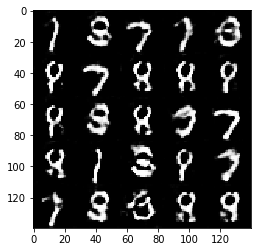

Epoch 2/2... Discriminator Loss: 0.6286... Generator Loss: 2.7368
Epoch 2/2... Discriminator Loss: 0.7028... Generator Loss: 1.7208
Epoch 2/2... Discriminator Loss: 2.3480... Generator Loss: 5.8834
Epoch 2/2... Discriminator Loss: 0.5954... Generator Loss: 2.4997
Epoch 2/2... Discriminator Loss: 0.7004... Generator Loss: 1.6588
Epoch 2/2... Discriminator Loss: 0.7917... Generator Loss: 1.4230
Epoch 2/2... Discriminator Loss: 0.7716... Generator Loss: 2.9392
Epoch 2/2... Discriminator Loss: 0.8235... Generator Loss: 2.0418
Epoch 2/2... Discriminator Loss: 0.8749... Generator Loss: 1.2170
Epoch 2/2... Discriminator Loss: 0.7363... Generator Loss: 1.3577


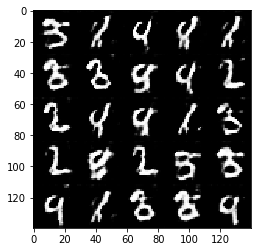

Epoch 2/2... Discriminator Loss: 1.3224... Generator Loss: 3.8303
Epoch 2/2... Discriminator Loss: 0.7646... Generator Loss: 1.3488
Epoch 2/2... Discriminator Loss: 0.9238... Generator Loss: 1.8244
Epoch 2/2... Discriminator Loss: 0.7497... Generator Loss: 2.2400
Epoch 2/2... Discriminator Loss: 0.6825... Generator Loss: 2.0024
Epoch 2/2... Discriminator Loss: 0.5887... Generator Loss: 2.6330
Epoch 2/2... Discriminator Loss: 0.6192... Generator Loss: 2.1367
Epoch 2/2... Discriminator Loss: 0.7027... Generator Loss: 1.8435
Epoch 2/2... Discriminator Loss: 1.1026... Generator Loss: 0.7954
Epoch 2/2... Discriminator Loss: 0.6887... Generator Loss: 3.0177


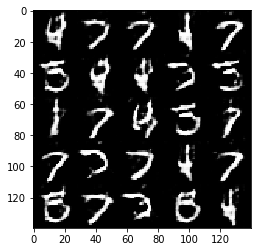

Epoch 2/2... Discriminator Loss: 0.7835... Generator Loss: 1.3122
Epoch 2/2... Discriminator Loss: 1.1752... Generator Loss: 0.8660
Epoch 2/2... Discriminator Loss: 0.8537... Generator Loss: 1.3006
Epoch 2/2... Discriminator Loss: 0.7719... Generator Loss: 1.6953
Epoch 2/2... Discriminator Loss: 0.8047... Generator Loss: 1.3036
Epoch 2/2... Discriminator Loss: 0.7133... Generator Loss: 1.8587
Epoch 2/2... Discriminator Loss: 0.6757... Generator Loss: 1.7396


In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.9402... Generator Loss: 1.7356
Epoch 1/1... Discriminator Loss: 2.8442... Generator Loss: 1.0088
Epoch 1/1... Discriminator Loss: 2.5736... Generator Loss: 2.5880
Epoch 1/1... Discriminator Loss: 1.2317... Generator Loss: 1.9697
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.7851
Epoch 1/1... Discriminator Loss: 0.8472... Generator Loss: 1.4111
Epoch 1/1... Discriminator Loss: 0.5180... Generator Loss: 2.6377
Epoch 1/1... Discriminator Loss: 0.7455... Generator Loss: 1.5329
Epoch 1/1... Discriminator Loss: 0.7114... Generator Loss: 1.5911
Epoch 1/1... Discriminator Loss: 1.6600... Generator Loss: 1.0372


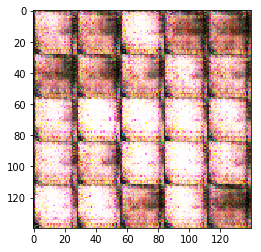

Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 1.5559
Epoch 1/1... Discriminator Loss: 1.8334... Generator Loss: 0.7773
Epoch 1/1... Discriminator Loss: 1.5868... Generator Loss: 0.4766
Epoch 1/1... Discriminator Loss: 1.1003... Generator Loss: 1.0289
Epoch 1/1... Discriminator Loss: 1.5378... Generator Loss: 0.7076
Epoch 1/1... Discriminator Loss: 1.3738... Generator Loss: 0.9087
Epoch 1/1... Discriminator Loss: 1.6026... Generator Loss: 0.6580
Epoch 1/1... Discriminator Loss: 1.4832... Generator Loss: 0.9482
Epoch 1/1... Discriminator Loss: 1.6431... Generator Loss: 0.6730
Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.7538


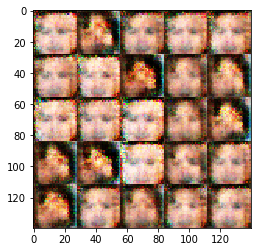

Epoch 1/1... Discriminator Loss: 1.0978... Generator Loss: 1.8413
Epoch 1/1... Discriminator Loss: 1.3171... Generator Loss: 0.6816
Epoch 1/1... Discriminator Loss: 1.5109... Generator Loss: 0.7203
Epoch 1/1... Discriminator Loss: 1.7064... Generator Loss: 0.5524
Epoch 1/1... Discriminator Loss: 1.4904... Generator Loss: 1.0070
Epoch 1/1... Discriminator Loss: 1.9530... Generator Loss: 0.5607
Epoch 1/1... Discriminator Loss: 1.6197... Generator Loss: 0.9761
Epoch 1/1... Discriminator Loss: 1.6084... Generator Loss: 0.6495
Epoch 1/1... Discriminator Loss: 1.5666... Generator Loss: 0.7431
Epoch 1/1... Discriminator Loss: 1.6224... Generator Loss: 0.7235


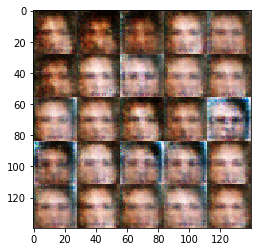

Epoch 1/1... Discriminator Loss: 1.5194... Generator Loss: 0.7153
Epoch 1/1... Discriminator Loss: 1.4835... Generator Loss: 0.7888
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 1.5157... Generator Loss: 0.8866
Epoch 1/1... Discriminator Loss: 1.5807... Generator Loss: 0.7211
Epoch 1/1... Discriminator Loss: 1.5673... Generator Loss: 0.7777
Epoch 1/1... Discriminator Loss: 1.5244... Generator Loss: 0.6586
Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.8644
Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.9543
Epoch 1/1... Discriminator Loss: 1.4565... Generator Loss: 0.7387


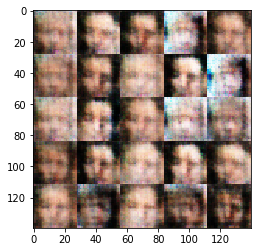

Epoch 1/1... Discriminator Loss: 1.5914... Generator Loss: 0.7777
Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 0.8711
Epoch 1/1... Discriminator Loss: 1.3271... Generator Loss: 0.8307
Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 0.8600
Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.9570
Epoch 1/1... Discriminator Loss: 1.7845... Generator Loss: 0.6189
Epoch 1/1... Discriminator Loss: 1.4554... Generator Loss: 0.7260
Epoch 1/1... Discriminator Loss: 1.5069... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.2415... Generator Loss: 0.9493
Epoch 1/1... Discriminator Loss: 1.4286... Generator Loss: 0.8443


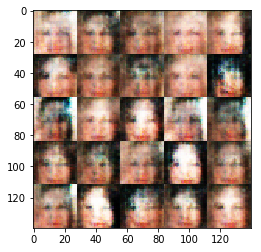

Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.8515
Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.8608
Epoch 1/1... Discriminator Loss: 1.4550... Generator Loss: 0.8026
Epoch 1/1... Discriminator Loss: 1.4960... Generator Loss: 0.7768
Epoch 1/1... Discriminator Loss: 1.5050... Generator Loss: 0.7291
Epoch 1/1... Discriminator Loss: 1.4906... Generator Loss: 0.8068
Epoch 1/1... Discriminator Loss: 1.2382... Generator Loss: 0.9103
Epoch 1/1... Discriminator Loss: 1.2727... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.8522
Epoch 1/1... Discriminator Loss: 1.2716... Generator Loss: 0.9631


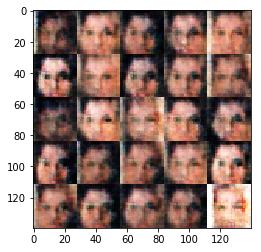

Epoch 1/1... Discriminator Loss: 1.4995... Generator Loss: 0.7937
Epoch 1/1... Discriminator Loss: 1.5572... Generator Loss: 0.7529
Epoch 1/1... Discriminator Loss: 1.8431... Generator Loss: 0.5599
Epoch 1/1... Discriminator Loss: 1.4303... Generator Loss: 0.7617
Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.8769
Epoch 1/1... Discriminator Loss: 1.4579... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 1.5610... Generator Loss: 0.7113
Epoch 1/1... Discriminator Loss: 1.4414... Generator Loss: 0.6944
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.7859
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.8255


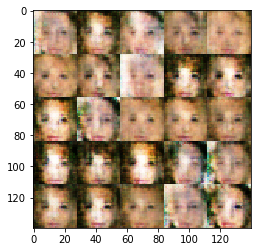

Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.9074
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.8119
Epoch 1/1... Discriminator Loss: 1.3511... Generator Loss: 0.8139
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.8394
Epoch 1/1... Discriminator Loss: 1.4376... Generator Loss: 0.7574
Epoch 1/1... Discriminator Loss: 1.5970... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 1.5450... Generator Loss: 0.7643
Epoch 1/1... Discriminator Loss: 1.3201... Generator Loss: 0.8433
Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.7808
Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.7129


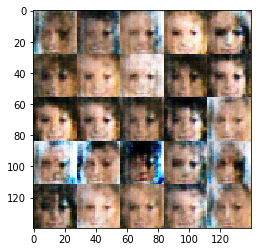

Epoch 1/1... Discriminator Loss: 1.6768... Generator Loss: 0.7077
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.4891... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 1.6445... Generator Loss: 0.6974
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.7218
Epoch 1/1... Discriminator Loss: 1.3733... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.7479
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.8169
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.8542
Epoch 1/1... Discriminator Loss: 1.3423... Generator Loss: 0.8168


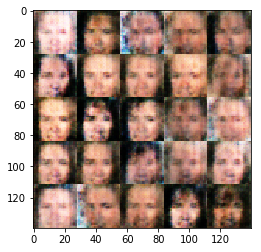

Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.8373
Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.8198
Epoch 1/1... Discriminator Loss: 1.4620... Generator Loss: 0.7515
Epoch 1/1... Discriminator Loss: 1.4834... Generator Loss: 0.7683
Epoch 1/1... Discriminator Loss: 1.4883... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.7803
Epoch 1/1... Discriminator Loss: 1.5152... Generator Loss: 0.7804
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.7947
Epoch 1/1... Discriminator Loss: 1.4700... Generator Loss: 0.7479
Epoch 1/1... Discriminator Loss: 1.5613... Generator Loss: 0.6971


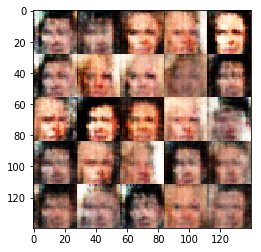

Epoch 1/1... Discriminator Loss: 1.5718... Generator Loss: 0.7098
Epoch 1/1... Discriminator Loss: 1.2257... Generator Loss: 0.8822
Epoch 1/1... Discriminator Loss: 1.4279... Generator Loss: 0.8055
Epoch 1/1... Discriminator Loss: 1.3572... Generator Loss: 0.8668
Epoch 1/1... Discriminator Loss: 1.4954... Generator Loss: 0.7230
Epoch 1/1... Discriminator Loss: 1.5291... Generator Loss: 0.7095
Epoch 1/1... Discriminator Loss: 1.4770... Generator Loss: 0.7850
Epoch 1/1... Discriminator Loss: 1.4650... Generator Loss: 0.7494
Epoch 1/1... Discriminator Loss: 1.4784... Generator Loss: 0.7037
Epoch 1/1... Discriminator Loss: 1.4513... Generator Loss: 0.8028


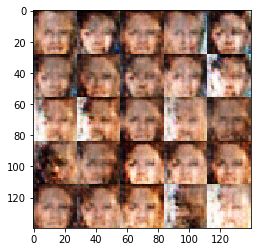

Epoch 1/1... Discriminator Loss: 1.4569... Generator Loss: 0.7286
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.7857
Epoch 1/1... Discriminator Loss: 1.4731... Generator Loss: 0.6959
Epoch 1/1... Discriminator Loss: 1.3528... Generator Loss: 0.8775
Epoch 1/1... Discriminator Loss: 1.4556... Generator Loss: 0.7232
Epoch 1/1... Discriminator Loss: 1.3111... Generator Loss: 0.8511
Epoch 1/1... Discriminator Loss: 1.5257... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 1.3416... Generator Loss: 0.7968
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.8562
Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 0.8039


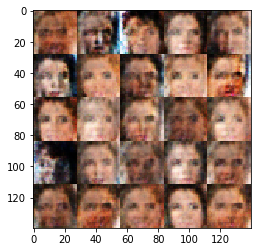

Epoch 1/1... Discriminator Loss: 1.4460... Generator Loss: 0.7475
Epoch 1/1... Discriminator Loss: 1.4546... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 1.3264... Generator Loss: 0.8604
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.7115
Epoch 1/1... Discriminator Loss: 1.4624... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.7825
Epoch 1/1... Discriminator Loss: 1.4931... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.8071
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.7604
Epoch 1/1... Discriminator Loss: 1.5443... Generator Loss: 0.7089


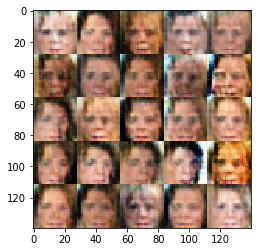

Epoch 1/1... Discriminator Loss: 1.4734... Generator Loss: 0.7095
Epoch 1/1... Discriminator Loss: 1.5496... Generator Loss: 0.7418
Epoch 1/1... Discriminator Loss: 1.5635... Generator Loss: 0.6952
Epoch 1/1... Discriminator Loss: 1.4970... Generator Loss: 0.7249
Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.7736
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.8209
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.8564
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.7646


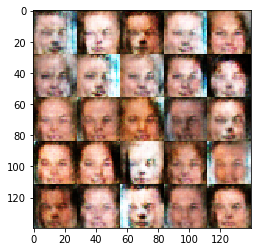

Epoch 1/1... Discriminator Loss: 1.4737... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.7930
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.8016
Epoch 1/1... Discriminator Loss: 1.4787... Generator Loss: 0.7404
Epoch 1/1... Discriminator Loss: 1.4856... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 0.7695
Epoch 1/1... Discriminator Loss: 1.5402... Generator Loss: 0.6596
Epoch 1/1... Discriminator Loss: 1.4737... Generator Loss: 0.7732
Epoch 1/1... Discriminator Loss: 1.3773... Generator Loss: 0.8218
Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.7735


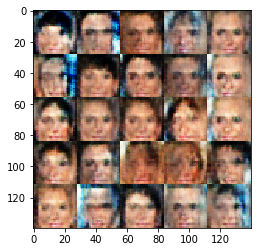

Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.7221
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.8196
Epoch 1/1... Discriminator Loss: 1.4612... Generator Loss: 0.7633
Epoch 1/1... Discriminator Loss: 1.3420... Generator Loss: 0.8232
Epoch 1/1... Discriminator Loss: 1.3441... Generator Loss: 0.8036
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 1.4551... Generator Loss: 0.7300
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.8117


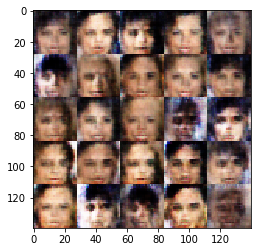

Epoch 1/1... Discriminator Loss: 1.4996... Generator Loss: 0.7574
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.8221
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.8123
Epoch 1/1... Discriminator Loss: 1.4416... Generator Loss: 0.8034
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.8143
Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.8012
Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.7451
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.7699
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 1.4483... Generator Loss: 0.7717


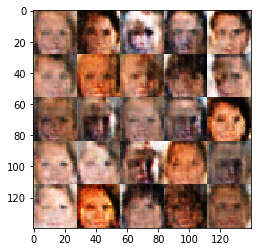

Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.7749
Epoch 1/1... Discriminator Loss: 1.4636... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.3862... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.8863
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.7660
Epoch 1/1... Discriminator Loss: 1.3269... Generator Loss: 0.8267
Epoch 1/1... Discriminator Loss: 1.5028... Generator Loss: 0.7902
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.8204
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.7558
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.7950


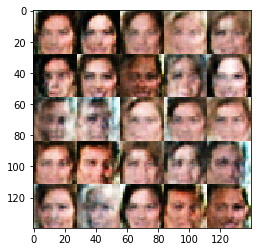

Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.6976
Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.8063
Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.7629
Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 0.8586
Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 0.7126
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.3524... Generator Loss: 0.7942
Epoch 1/1... Discriminator Loss: 1.4664... Generator Loss: 0.7204
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.8092
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.8158


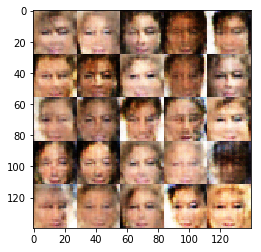

Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 1.4479... Generator Loss: 0.7046
Epoch 1/1... Discriminator Loss: 1.3951... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.7772
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.7702
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.7835
Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 0.8099
Epoch 1/1... Discriminator Loss: 1.4425... Generator Loss: 0.7510
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.7243
Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.7483


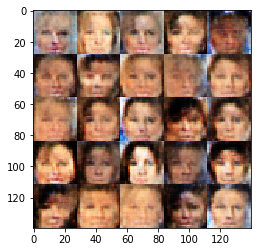

Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.8019
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.8426
Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.8841
Epoch 1/1... Discriminator Loss: 1.4364... Generator Loss: 0.7271
Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.7398
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.7975
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.7624


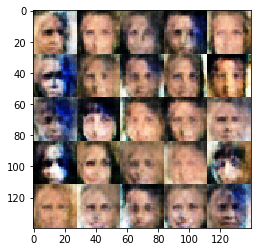

Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.7863
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 1.4521... Generator Loss: 0.7472
Epoch 1/1... Discriminator Loss: 1.4752... Generator Loss: 0.7337
Epoch 1/1... Discriminator Loss: 1.3456... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.7282
Epoch 1/1... Discriminator Loss: 1.3268... Generator Loss: 0.8352
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.7732
Epoch 1/1... Discriminator Loss: 1.4641... Generator Loss: 0.6748


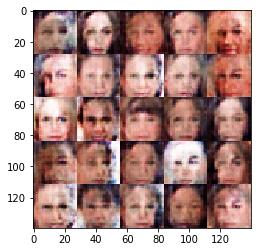

Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.4326... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.7934
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.7788
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.7186
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.7174
Epoch 1/1... Discriminator Loss: 1.4566... Generator Loss: 0.7188
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.8295
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.8305
Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.7628


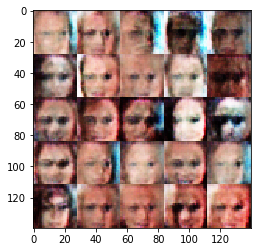

Epoch 1/1... Discriminator Loss: 1.4760... Generator Loss: 0.7305
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.7790
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.7592
Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.8946
Epoch 1/1... Discriminator Loss: 1.4587... Generator Loss: 0.8584
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.7993
Epoch 1/1... Discriminator Loss: 1.4529... Generator Loss: 0.7508
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.7480
Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.8203
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.7570


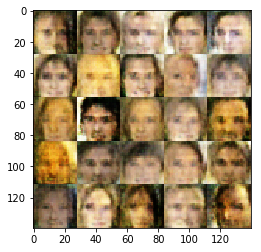

Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.7391
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.7533
Epoch 1/1... Discriminator Loss: 1.4621... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.7590
Epoch 1/1... Discriminator Loss: 1.3890... Generator Loss: 0.7938
Epoch 1/1... Discriminator Loss: 1.4235... Generator Loss: 0.7369
Epoch 1/1... Discriminator Loss: 1.4042... Generator Loss: 0.7556
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.8256
Epoch 1/1... Discriminator Loss: 1.4785... Generator Loss: 0.7422
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.8011


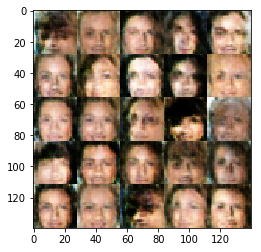

Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.8041
Epoch 1/1... Discriminator Loss: 1.4489... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.4388... Generator Loss: 0.8152
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.7129
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.8015
Epoch 1/1... Discriminator Loss: 1.3732... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.4536... Generator Loss: 0.7407
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.7880
Epoch 1/1... Discriminator Loss: 1.4600... Generator Loss: 0.8294
Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 0.7825


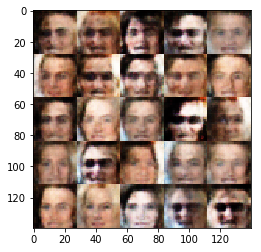

Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.8088
Epoch 1/1... Discriminator Loss: 1.3270... Generator Loss: 0.8223
Epoch 1/1... Discriminator Loss: 1.4353... Generator Loss: 0.7169
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.7759
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.4572... Generator Loss: 0.8171
Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.7573
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.7835
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.7838
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.7898


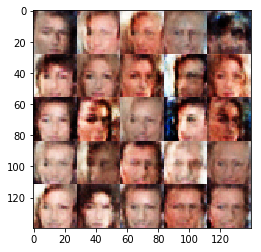

Epoch 1/1... Discriminator Loss: 1.3392... Generator Loss: 0.8221
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.8349
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.7937
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.8206
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.7409
Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.7352
Epoch 1/1... Discriminator Loss: 1.4404... Generator Loss: 0.7543
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.7307
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.8325


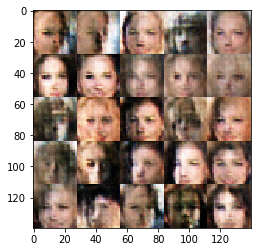

Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.7357
Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.7995
Epoch 1/1... Discriminator Loss: 1.3244... Generator Loss: 0.8333
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.7960
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.6613
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.7659
Epoch 1/1... Discriminator Loss: 1.4534... Generator Loss: 0.7225
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.8047
Epoch 1/1... Discriminator Loss: 1.4868... Generator Loss: 0.7423


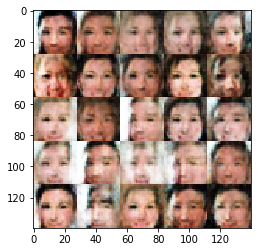

Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.7392
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.7352
Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.8702
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.8847
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.7692
Epoch 1/1... Discriminator Loss: 1.2922... Generator Loss: 0.9746
Epoch 1/1... Discriminator Loss: 1.4104... Generator Loss: 0.8117
Epoch 1/1... Discriminator Loss: 1.4529... Generator Loss: 0.6665
Epoch 1/1... Discriminator Loss: 1.3333... Generator Loss: 0.7767


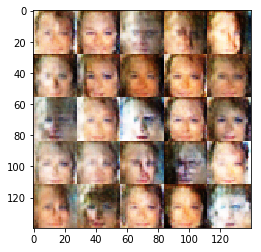

Epoch 1/1... Discriminator Loss: 1.4809... Generator Loss: 0.7027
Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.8794
Epoch 1/1... Discriminator Loss: 1.5248... Generator Loss: 0.7702
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.6882
Epoch 1/1... Discriminator Loss: 1.4620... Generator Loss: 0.6796
Epoch 1/1... Discriminator Loss: 1.5754... Generator Loss: 0.5954
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.7600
Epoch 1/1... Discriminator Loss: 1.3562... Generator Loss: 0.7495
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.7908
Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 0.7966


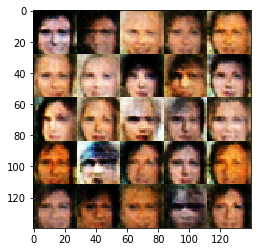

Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.7045
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.8214
Epoch 1/1... Discriminator Loss: 1.4338... Generator Loss: 0.7211
Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.7401
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.7494
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.8244


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0004
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.